In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import torch.utils.data as data
import torch
from torch import nn, optim
import torch.nn.functional as F
import tqdm
from tqdm import tnrange
import copy

C:\Users\franc\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('data.csv', delimiter=",")
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
df_eval = pd.read_csv('evaluation_data.csv', delimiter=",")
df_eval.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-20,1,0,1,0,0,4,1,1,0.26,0.2273,0.56,0.3881
1,2011-01-20,1,0,1,1,0,4,1,1,0.26,0.2727,0.56,0.0000
2,2011-01-20,1,0,1,2,0,4,1,1,0.26,0.2727,0.56,0.0000
3,2011-01-20,1,0,1,3,0,4,1,1,0.26,0.2576,0.56,0.1642
4,2011-01-20,1,0,1,4,0,4,1,1,0.26,0.2576,0.56,0.1642


In [4]:
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

In [5]:
df_cas = df.drop(columns=['dteday', 'cnt', 'registered', 'instant']).astype(float)
df_reg = df.drop(columns=['dteday', 'cnt', 'casual', 'instant']).astype(float)
df_eval = df_eval.drop(columns=['dteday']).astype(float)

In [6]:
train_dataset_cas = data.TensorDataset(torch.from_numpy(df_cas.values[:,:-1]).float(), torch.from_numpy(df_cas.values[:,-1]).float())
train_dataset_reg = data.TensorDataset(torch.from_numpy(df_reg.values[:,:-1]).float(), torch.from_numpy(df_reg.values[:,-1]).float())

train_data_loader_cas = data.DataLoader(train_dataset_cas, batch_size=10, shuffle=True)
train_data_loader_reg = data.DataLoader(train_dataset_cas, batch_size=10, shuffle=True)

In [7]:
model = SimpleClassifier(num_inputs=12, num_hidden=4, num_outputs=1)

In [8]:
def get_trained_model(data_loader, criterion, optimizer):
    model.train() 
    epochs = 150
    train_losses = []

    # Training loop
    for epoch in range(epochs):
        train_loss = 0
        for data_inputs, data_labels in data_loader:

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            # data_inputs = data_inputs.to(device)
            # data_labels = data_labels.to(device)

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

            ## Step 3: Calculate the loss
            loss = criterion(preds, data_labels.float())
            train_loss += loss.item()

            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero. 
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad() 
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()
        train_losses.append(train_loss/len(data_loader))
        print(f"Epoch: {epoch}, loss: {train_loss/len(data_loader)}")

    return model, train_losses

In [9]:
criterion = nn.MSELoss()
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
model_cas, train_losses_cas = get_trained_model(train_data_loader_cas, criterion, optimizer)

Epoch: 0, loss: 3735.9902157533925
Epoch: 1, loss: 3696.2748517823725
Epoch: 2, loss: 3656.952745635538
Epoch: 3, loss: 3625.4402017059188
Epoch: 4, loss: 3590.0370645321655
Epoch: 5, loss: 3558.089081534779
Epoch: 6, loss: 3527.4173311438444
Epoch: 7, loss: 3500.315816993118
Epoch: 8, loss: 3465.4586576333936
Epoch: 9, loss: 3435.470293331409
Epoch: 10, loss: 3406.9419904206193
Epoch: 11, loss: 3377.4150533719935
Epoch: 12, loss: 3349.6961372627698
Epoch: 13, loss: 3321.7698006292785
Epoch: 14, loss: 3294.939586488778
Epoch: 15, loss: 3266.3012389926544
Epoch: 16, loss: 3240.155590341111
Epoch: 17, loss: 3214.476616688668
Epoch: 18, loss: 3189.0022726242864
Epoch: 19, loss: 3164.8661097657036
Epoch: 20, loss: 3141.3461820621683
Epoch: 21, loss: 3113.861830256859
Epoch: 22, loss: 3089.3272347743628
Epoch: 23, loss: 3064.1982781731613
Epoch: 24, loss: 3041.2184288771027
Epoch: 25, loss: 3016.6767919994036
Epoch: 26, loss: 2994.501919496815
Epoch: 27, loss: 2969.702713774584
Epoch: 28, l

In [11]:
model_reg, train_losses_reg = get_trained_model(train_data_loader_reg, criterion, optimizer)

Epoch: 0, loss: 1539.2247288811634
Epoch: 1, loss: 1530.6059153620752
Epoch: 2, loss: 1523.8262771294685
Epoch: 3, loss: 1514.8799803622608
Epoch: 4, loss: 1508.747891463743
Epoch: 5, loss: 1501.2153162890559
Epoch: 6, loss: 1493.7378892434422
Epoch: 7, loss: 1489.0810004900748
Epoch: 8, loss: 1480.8415470806362
Epoch: 9, loss: 1476.48988558066
Epoch: 10, loss: 1468.503660245813
Epoch: 11, loss: 1462.9864876311892
Epoch: 12, loss: 1456.3866943380392
Epoch: 13, loss: 1451.189152797282
Epoch: 14, loss: 1445.020207982199
Epoch: 15, loss: 1440.9973482564571
Epoch: 16, loss: 1433.7518078477367
Epoch: 17, loss: 1428.83334740813
Epoch: 18, loss: 1422.5205236527763
Epoch: 19, loss: 1417.600700670913
Epoch: 20, loss: 1412.2502542395894
Epoch: 21, loss: 1407.411171821195
Epoch: 22, loss: 1402.057938893636
Epoch: 23, loss: 1400.1096477420972
Epoch: 24, loss: 1393.0242015849133
Epoch: 25, loss: 1387.2340885369026
Epoch: 26, loss: 1383.5411768196043
Epoch: 27, loss: 1377.7289350753097
Epoch: 28, lo

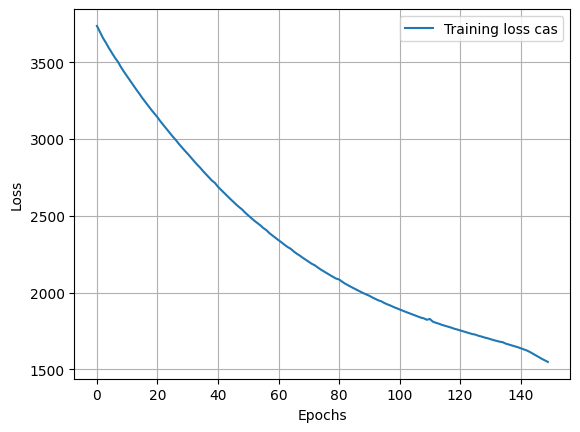

In [12]:
plt.plot(train_losses_cas, label='Training loss cas')
# plt.plot(val_losses_cas[frm:], label='Validation loss cas')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()

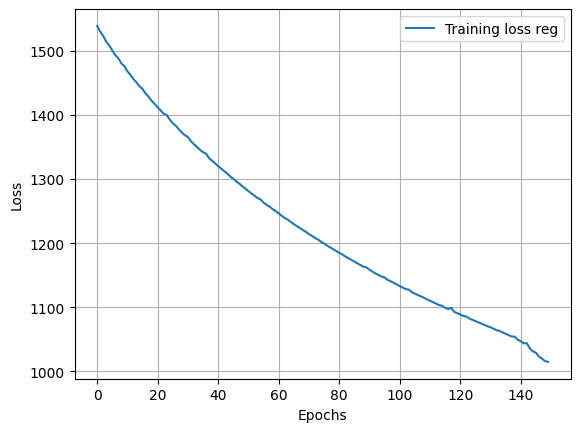

In [13]:
plt.plot(train_losses_reg, label='Training loss reg')
# plt.plot(val_losses_cas[frm:], label='Validation loss cas')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()

In [17]:
def predict(model, test_batch):
    # predicting for every batch
    test_outputs = []
    test_output = model(test_batch)
    for j in range(len(test_batch)):
        test_output = model(test_batch[j])
        for value in test_output:
            test_outputs.append(value)
            
    # tensor to list
    list_output = []
    for output in test_outputs:
        list_output.append(output.item())
    
    # list to dataframe
    df_output = pd.DataFrame(list_output)
    
    return df_output

In [23]:
test_dataset = torch.from_numpy(df_eval.values).float()
test_dataset

tensor([[ 1.0000,  0.0000,  1.0000,  ...,  0.2273,  0.5600,  0.3881],
        [ 1.0000,  0.0000,  1.0000,  ...,  0.2727,  0.5600,  0.0000],
        [ 1.0000,  0.0000,  1.0000,  ...,  0.2727,  0.5600,  0.0000],
        ...,
        [ 1.0000,  1.0000, 12.0000,  ...,  0.2576,  0.6000,  0.1642],
        [ 1.0000,  1.0000, 12.0000,  ...,  0.2727,  0.5600,  0.1343],
        [ 1.0000,  1.0000, 12.0000,  ...,  0.2727,  0.6500,  0.1343]])

In [24]:
preds_cas = predict(model_cas, test_dataset)

In [26]:
preds_reg = predict(model_reg, test_dataset)

In [27]:
df_output = preds_cas + preds_reg

In [28]:
df_output = preds_cas + preds_reg

In [29]:
# saving to file
df_output.to_csv('muchomorki.csv', header=False, index=False)

In [30]:
df_output.describe()

,0
count,6493.000000
mean,66.305161
std,60.863288
min,-53.416904
25%,23.188305
50%,43.745708
75%,109.458344
max,193.673386
